In [171]:
import json, os
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import itertools


We need to cover the following cases:
1. **Problem**: Assignment Expression has several values (e.g., concat)
    - **Solution**: Store ExprAssignment().list_expr as `list`
2. **Problem**: If-Else Statements result in several graph possibilities
    - **Solution**: Generate one graph for holding graphs

In [172]:
# '1a-basic-flow'
# '1b-basic-flow'
# '2-expr-binary-ops'
# '3a-expr-func-calls'
# '4a-conds-branching'
# '4b-conds-branching.php'

TEST_SlICE = '5a-loops-unfolding'

In [173]:
with open(os.path.join('testSlices', TEST_SlICE + '.json')) as json_file:
    slices = json.load(json_file)

with open(os.path.join('testPatterns', TEST_SlICE + '.patterns.json')) as json_file:
    patterns = json.load(json_file)

FileNotFoundError: [Errno 2] No such file or directory: 'testSlices\\5a-loops-unfolding.patterns.json'

Initialize Classes

In [ ]:
class Stmt_Expression():
    def __init__(self, expr):
        self.expr = expr
    
    def __repr__(self):
        return f"Stmt_Expression({self.expr})"

class Expr_Assign():
    def __init__(self, var, list_expr):
        self.var = var
        self.list_expr = list_expr
    def __repr__(self):
        str_list_expr = ", ".join(str(expr) for expr in self.list_expr)
        return f"{self.var} = {str_list_expr}"

class Expr_FuncCall():
    def __init__(self, name, args=[]):
        self.name = name
        self.args = args
    def __str__(self):
        str_args = ", ".join(str(arg) for arg in self.args)
        return f"{self.name}({str_args})"
    def __repr__(self):
        return f"{self.name}()"

class Stmt_While():
    def __init__(self, condition, whileBlock):
        self.condition = condition
        self.whileBlock = whileBlock
    def __repr__(self) -> str:
        str_whileBlock = ";\n".join(f'\t{stmt}' for stmt in self.whileBlock)
        str_while = f"while({self.condition})\n[{str_whileBlock}]"
        return str_while


class Stmt_If_Else():
    def __init__(self, condition, ifBlock, elseIfs, elseBlock):
        self.condition = condition 
        self.ifBlock = ifBlock
        self.elseIfs = elseIfs
        self.elseBlock = elseBlock
    def __repr__(self):
        str_ifBlock = ";\n".join(f'\t{stmt}' for stmt in self.ifBlock)
        str_stmt_if = f"if({self.condition})[\n{str_ifBlock}]"
        if len(self.elseIfs) > 0:
            str_stmt_if += f"\nelseIf[\n\t{self.elseIfs}]"
        if len(self.elseBlock) > 0:
            str_elseBlock = ";\n".join(f'\t{stmt}' for stmt in self.elseBlock)
            str_stmt_if += f"\nelse[\n{str_elseBlock}]"
        return str_stmt_if

class Expr_Variable():
    def __init__(self, name):
        self.name = name
        self.assigned = False
    def __repr__(self):
        return f"${self.name}"
    def __eq__(self, other):
        # Check if the other object is an Assignment and has the same left and right values
        if isinstance(other, Expr_Variable) and self.name == other.name and not self.assigned:
            return True
        return False
    def __hash__(self):
        # Return a unique and immutable value based on the left and right values
        return hash(self.name)

class Constant():
    def __init__(self, value):
        self.value = value
    def __repr__(self):
        return f"Constant(value={self.value})"

class Stmt_Nop():
    def __init__(self, value):
        self.value = value
    def __repr__(self):
        return f"Nop(value={self.value})"
        

class Expr_BinaryOp_Concat():
    def __init__(self, left, right):
        self.left = left
        self.right = right
    def __repr__(self):
        return f"{self.left}, {self.right}"

class Expr_BinaryOp_Greater():
    def __init__(self, left, right):
        self.left = left
        self.right = right
    def __repr__(self):
        return f"{self.left}>{self.right}"

class Expr_BinaryOp_Smaller():
    def __init__(self, left, right):
        self.left = left
        self.right = right
    def __repr__(self):
        return f"{self.left}<{self.right}"


class Program():
    def __init__(self, steps):
        self.steps = steps
    def __repr__(self):
        str_steps = '\n'.join(f'\t{idx}. {step}' for idx, step in enumerate(self.steps))
        return f'\n{str_steps}\n'

Recusive Function to convert the input slices into class objects

In [ ]:
def flatten(lst):
    flat_list = []
    for item in lst:
        if isinstance(item, list):
            flat_list.extend(flatten(item))
        else:
            flat_list.append(item)
    return flat_list
    
def process_json(obj):
    if isinstance(obj, dict):
        #if obj["nodeType"] == 'Stmt_Else':
        #    block = [process_json(stmt) for stmt in obj["stmts"]]
        #    return Stmt_Else(block)
        if obj["nodeType"] == 'Stmt_While':
            condition = process_json(obj["cond"])
            whileBlock = [process_json(stmt) for stmt in obj["stmts"]]
            return Stmt_While(condition, whileBlock)
        if obj["nodeType"] == 'Stmt_If':
            condition = process_json(obj["cond"])
            ifBlock = [process_json(stmt) for stmt in obj["stmts"]]
            elseIfs = [process_json(elifs) for elifs in obj["elseifs"]]
            elseBlock = [] if obj["else"] is None else [process_json(stmt) for stmt in obj["else"]["stmts"]]
            return Stmt_If_Else(condition, ifBlock, elseIfs, elseBlock)
        if obj["nodeType"] == 'Stmt_Expression':
            return process_json(obj["expr"])
        if obj["nodeType"] == "Expr_Assign":
            var = process_json(obj["var"])
            list_expr = [process_json(obj["expr"])]
            return Expr_Assign(var, list_expr)
        if obj["nodeType"] == "Expr_FuncCall":
            name = obj["name"]["parts"][0]
            args = flatten([process_json(arg) for arg in obj["args"]])
            return Expr_FuncCall(name, args)
        if obj["nodeType"] == "Expr_BinaryOp_Concat":
            left = process_json(obj["left"])
            right = process_json(obj["right"])
            return flatten([left, right])
        if obj["nodeType"] == "Expr_BinaryOp_Greater":
            left = process_json(obj["left"])
            right = process_json(obj["right"])
            return Expr_BinaryOp_Greater(left, right)
        if obj["nodeType"] == "Expr_BinaryOp_Smaller":
            left = process_json(obj["left"])
            right = process_json(obj["right"])
            return Expr_BinaryOp_Smaller(left, right)
        if obj["nodeType"] == "Arg":
            return process_json(obj["value"])
        if obj["nodeType"] == "Expr_Variable":
            return Expr_Variable(obj["name"])
        if obj["nodeType"] == "Scalar_String":
            return Constant(obj["value"])
        if obj["nodeType"] == "Scalar_LNumber":
            return Constant(obj["value"])
        if obj["nodeType"] == "Stmt_Nop":
            return Stmt_Nop("Nop")
    elif isinstance(obj, list):
        steps = [process_json(step) for step in obj]
        return Program(steps)
    else:
        # this is for error catching :)
        return None
        print(obj)

# Process the JSON object
parsed_ast = process_json(slices)

Print the program in a readable format

In [ ]:
parsed_ast


	0. z(t(a(Constant(value=username))))
	1. Nop(value=Nop)

In [ ]:
class CustomGraph:
    def __init__(self, name):
        self.nodes = set([])
        self.edges = []
        self.name = name

    def add_node(self,node):
        self.nodes.add(node)
        
    def remove_node(self,node):
        self.nodes.remove(node)

    def add_edge(self,firstNode, secondNode):
        self.nodes.add(firstNode)
        self.nodes.add(secondNode)
        self.edges.append((firstNode,secondNode))

    def remove_edge(self, firstNode, secondNode):
        self.edges.remove((firstNode, secondNode))

    def has_node(self, node, evalMode=False):
        if evalMode: #Currently not used and replaced by get_node_from_repr()
            return str(node) in [repr(n) for n in self.nodes]
        else:
            return node in self.nodes

    def get_node_from_repr(self, node):
        if self.has_node(node, evalMode=True):
            for n in self.nodes:
                if str(node) == repr(n):
                    return n
        else:
            return None

    def in_edges(self, node):
        edgesFound = []
        for edge in self.edges:
            if node in edge:
                edgesFound.append(edge)
        return edgesFound

    def successors(self, node, evalMode=False):
        successors = []
        for pair in self.edges:
            if evalMode:
                if repr(pair[0]) == str(node):
                    successors.append(repr(pair[1]))
            else:
                if pair[0] == node:
                    successors.append(pair[1])
        return successors

    def predecessors(self, node, evalMode=False):
        successors = []
        for pair in self.edges:
            if evalMode:
                if repr(pair[1]) == str(node):
                    successors.append(repr(pair[0]))
            else:
                if pair[1] == node:
                    successors.append(pair[0])
        return successors
    
    def add_edges_from(self, edges):
        for edge in edges:
            if edge not in self.edges:
                self.nodes.add(edge[0])
                self.nodes.add(edge[1])
                self.edges.append(edge)

    def __repr__(self):
        return f"{self.name}"

Recusively create a graph based on the program

In [ ]:
codeBlockCounter = 1

# Function to recursively find all assignments in the AST
def create_graph(node, programGraph, graph):
    global codeBlockCounter

    if isinstance(node, Expr_Assign):

        #if graph.has_node(str(node.var)):
        #    # If the variable isn't referenced anywhere, it is overwritten
        #    if len(list(graph.successorsnew_endifGraph(str(node.var)))) == 0:
        #        for u, v in list(graph.in_edges(str(node.var))):
        #            graph.remove_edge(u, v)
        #            graph.remove_node(u)

        for expr in node.list_expr:
            if isinstance(expr, Expr_FuncCall):
                graph.add_edge(expr, node.var)
                create_graph(expr, programGraph, graph)
            if isinstance(expr, Constant):
                graph.add_edge(expr, node.var)
            if isinstance(expr, Expr_Variable):
                graph.add_edge(expr, node.var)

    if isinstance(node, Expr_FuncCall):
        for arg in node.args:
            graph.add_edge(arg, node)
            create_graph(arg, programGraph, graph)

    if isinstance(node, Stmt_If_Else):
        #validate if there is assignment in the if condiction (it is possible!)
        create_graph(node.condition, programGraph, graph)
        
        #we generate a code block for if the statement is true
        codeBlockCounter += 1
        new_ifGraph = CustomGraph(f"ifcodeBlock#{codeBlockCounter}")
        programGraph.add_edge(graph, new_ifGraph)
        connectifGraph = create_graph(node.ifBlock, programGraph, new_ifGraph)
        
        #FIXME This may need to change, need to test with else ifs
        if len(node.elseIfs) > 0:
            codeBlockCounter += 1
            new_ifGraph2 = CustomGraph(f"elifscodeBlock#{codeBlockCounter}")
            create_graph(node.elseIfs, programGraph, new_ifGraph2)
            programGraph.add_edge(graph, new_ifGraph2)
        
        #This is the else codeblock
        codeBlockCounter += 1
        new_elseGraph = CustomGraph(f"elsecodeBlock#{codeBlockCounter}")
        connectelseGraph = create_graph(node.elseBlock, programGraph,new_elseGraph)
        programGraph.add_edge(graph, new_elseGraph)
        

        #This is a new codeblock after the if and else statement
        #where I connect the if and else block to this new block
        #With the 4a example its the 5 and 7 blocks
        codeBlockCounter += 1
        new_endifGraph = CustomGraph(f"codeBlock#{codeBlockCounter}")
        programGraph.add_edge(connectelseGraph, new_endifGraph)
        programGraph.add_edge(connectifGraph, new_endifGraph)
        graph = new_endifGraph



    if isinstance(node, Stmt_While):
        create_graph(node.condition, programGraph, graph)
        
        #Running once
        codeBlockCounter += 1
        new_whileBlock = CustomGraph(f"whileBlock#{codeBlockCounter}")
        connectWhileGraph = create_graph(node.whileBlock, programGraph, new_whileBlock)
        programGraph.add_edge(graph, new_whileBlock)

        #Running twice
        codeBlockCounter += 1
        new_duppedwhileBlock1 = CustomGraph(f"duppedWhileBlock#{codeBlockCounter}")
        connectWhileGraph1 = create_graph(node.whileBlock, programGraph, new_duppedwhileBlock1)
        programGraph.add_edge(graph, new_duppedwhileBlock1)
        codeBlockCounter += 1
        new_duppedwhileBlock2 = CustomGraph(f"duppedWhileBlock#{codeBlockCounter}")
        programGraph.add_edge(connectWhileGraph1, new_duppedwhileBlock2)
        connectWhileGraph2 = create_graph(node.whileBlock, programGraph, new_duppedwhileBlock2)


        codeBlockCounter += 1
        new_endGraph = CustomGraph(f"codeBlock#{codeBlockCounter}")
        #Running none
        programGraph.add_edge(graph, new_endGraph)
        #Running once
        programGraph.add_edge(connectWhileGraph, new_endGraph)
        #Running twice
        programGraph.add_edge(connectWhileGraph2, new_endGraph)
        
        graph = new_endGraph

    if hasattr(node, 'steps'):
        for step in node.steps:
            graph = create_graph(step, programGraph, graph)

    elif isinstance(node, list):
        for stmt in node:
            graph = create_graph(stmt, programGraph, graph)

    return graph

# Create a graph for the code blocks
graph = CustomGraph(f"codeBlock#{codeBlockCounter}")

# Create a graph for the whole program
programGraph = CustomGraph("ProgramGraph")
programGraph.add_node(graph)

# Recusrively create the Program Graph consisting of graphs
create_graph(parsed_ast, programGraph, graph)
print()

Print the  program graph  and each single blocks graph

[codeBlock#1]


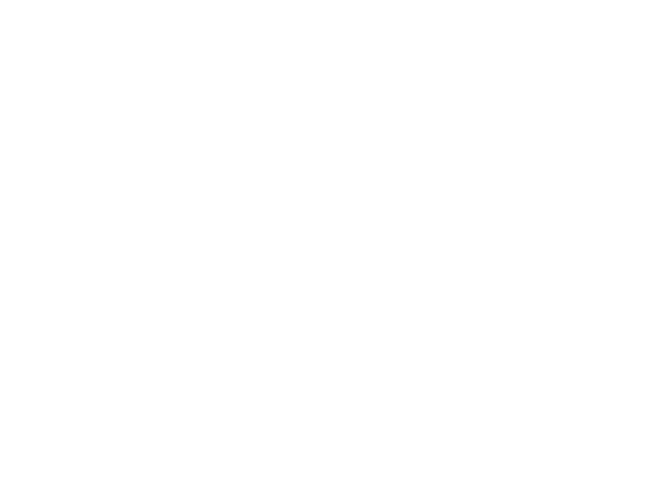

codeBlock#1


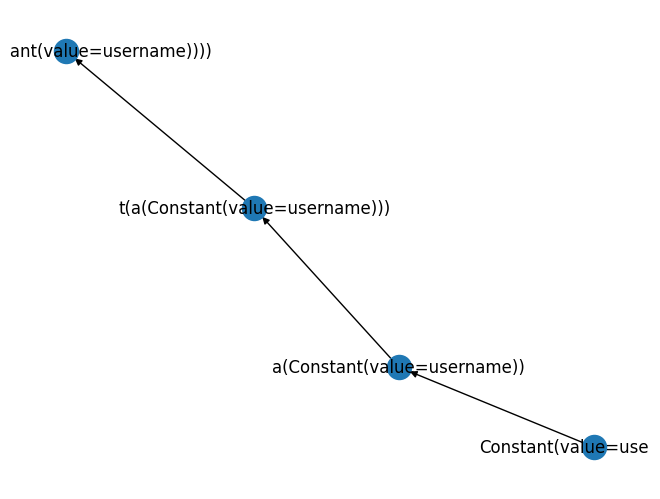

In [ ]:
# Use NetworkX's draw() function to draw the graph
debugGraph = nx.DiGraph()
debugGraph.add_edges_from(programGraph.edges)

print(list(programGraph.nodes))
nx.draw(debugGraph, with_labels=True)
plt.show()

# Loop through each codeBlocks graph and draw it
for nodeGraph in list(programGraph.nodes):
    print(nodeGraph)
    debugGraph = nx.DiGraph()
    debugGraph.add_edges_from(nodeGraph.edges)
    nx.draw(debugGraph, with_labels=True)
    plt.show()

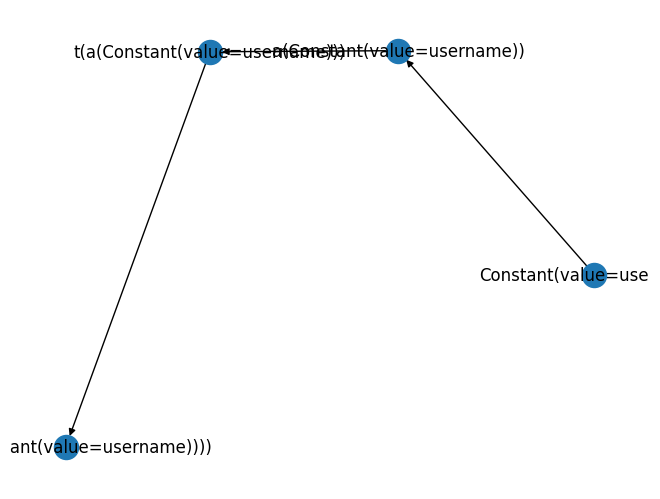

In [ ]:
def getPossibleProgramPaths(programGraph):
    def get_neighbours_all_nodes(programGraph):
        neighbours = {}
        for edge in programGraph.edges:
            if edge[0] not in neighbours.keys():
                neighbours[edge[0]] = [edge[1]]
            else:
                neighbours[edge[0]].append(edge[1])
        return neighbours
    def getPaths(visited, neighbours, node, endNode):
        if node == endNode:
            paths.append(visited)
        if node not in neighbours.keys():
            return 
        for neighbour in neighbours[node]:
            getPaths(visited + [neighbour,], neighbours, neighbour, endNode)

    #Output struture
    paths = []

    #This is a support structure to make it easier to traverse each nodes neighbours
    neighbours = get_neighbours_all_nodes(programGraph)

    # Try Except is necessary because sometimes there is only one node in the Program graph
    try:
        getPaths(
            [programGraph.edges[0][0]],
            neighbours,  
            programGraph.edges[0][0],
            programGraph.edges[-1][1]
        )
    except:
        paths = [[list(programGraph.nodes)[0]]]
    return paths

def getPossibleGraphs(lst:list) -> list:
    if isinstance(lst[0], CustomGraph):
        return_graph = CustomGraph(name="Final")
        for graph in lst:  
            return_graph.add_edges_from(graph.edges)
        return return_graph
    if isinstance(lst[0], list):
        return [getPossibleGraphs(combination) for combination in lst] 
    
listOfCombinations = getPossibleProgramPaths(programGraph)
listOfGraphs = getPossibleGraphs(listOfCombinations)

for combination in listOfCombinations:
    debugGraph = nx.DiGraph()
    for graph in combination:
        debugGraph.add_edges_from(list(graph.edges))
    nx.draw(debugGraph, with_labels=True)
    plt.show()


Function to generate all possible paths from the first node to the end node 

In [ ]:
def get_paths(graph, start, path=(),visitedEdges=()):
    path += (start,)
    if not graph.has_node(start, evalMode=False):
        return ()
    paths = ()
    for node in graph.successors(start):
        if (start,node) not in visitedEdges:
            visitedEdges += ((start,node),)
            new_paths = get_paths(graph, node, path, visitedEdges)
            for new_path in new_paths:
                paths+= (new_path,)
    if not paths:
        paths += (path,)
    return paths

def create_output_list(list_output: list, new_vulnerability: json) -> list:
    EXISTS = False
    for idx, known_vulnerability in enumerate(list_output):
        if all(known_vulnerability[key] == new_vulnerability[key] for key in ["vulnerability", "source", "sink"]):
            EXISTS = True
            if len(new_vulnerability["sanitized flows"]) == 0:
                list_output[idx]["unsanitized flows"] = "yes"
            else:
                list_output[idx]["sanitized flows"].append(new_vulnerability["sanitized flows"])
    if not EXISTS:
        list_output.append(new_vulnerability)
    return list_output

def usesUnitializedVariable(start, graph, noRepeatedNodes=()):
    for node in graph.predecessors(start, True):
        if node[0] == "$" and len(graph.predecessors(node, True)) == 0:
            return node
        else:
            if node not in noRepeatedNodes:
                noRepeatedNodes += (node,)
                usesUnitializedVariable(node, graph=graph, noRepeatedNodes=noRepeatedNodes)


def analyze_patterns(list_output: list,pattern: dict, graph: CustomGraph) -> dict:
    for source in pattern["sources"]:
        if "$" not in source: # FIXME: Maybe remove this from the graph 
            source += "()"
        possible_paths = get_paths(graph, graph.get_node_from_repr(source),(),()) # TODO: What happens if source occurs multiple times
        for sink in pattern["sinks"]:
            if "$" not in sink:
                sink += "()"
            if sink == source:
                continue
            for path in possible_paths:
                path = [repr(i) for i in path] # Here we convert it back to the representations
                if sink in path:
                    if pattern["implicit"] == 'yes' or (pattern["implicit"] == 'no' and path.index(sink) > 0):
                        sanitizers = []
                        for sanitize_func in pattern["sanitizers"]:
                            if sanitize_func + "()" in path:
                                if path.index(sanitize_func + "()") < path.index(sink):
                                    sanitizers.append(sanitize_func + "()")
                        
                        list_output = create_output_list(
                            list_output = list_output, 
                            new_vulnerability = {
                                "vulnerability": pattern["vulnerability"],
                                "source": source,
                                "sink": sink,
                                "unsanitized flows": "yes" if len(sanitizers) == 0 else "no",
                                "sanitized flows": sanitizers
                            }
                        )
    #For unitialized variables connected to sinks
    for sink in pattern["sinks"]:
        if "$" not in sink:
                sink += "()"
        for node in graph.predecessors(sink, True):
            #Check directly connected nodes
            if node[0] == "$" and len(graph.predecessors(node, True)) == 0:
                list_output = create_output_list(
                            list_output = list_output, 
                            new_vulnerability = {
                                "vulnerability": pattern["vulnerability"],
                                "source": node,
                                "sink": sink,
                                "unsanitized flows": "yes",
                                "sanitized flows": []
                            }
                        )
            else:
                #Check recursively if it comes from an unitialized variable
                testNode = usesUnitializedVariable(node, graph=graph)
                if not testNode is None:
                    list_output = create_output_list(
                                list_output = list_output, 
                                new_vulnerability = {
                                    "vulnerability": pattern["vulnerability"],
                                    "source": testNode,
                                    "sink": sink,
                                    "unsanitized flows": "yes",
                                    "sanitized flows": []
                                }
                            )
    return list_output

In [ ]:
output = []
for graph in listOfGraphs:
    for pattern in patterns:
        analyze_patterns(output,pattern, graph)
output

[{'vulnerability': 'A',
  'source': 'a()',
  'sink': 'z()',
  'unsanitized flows': 'no',
  'sanitized flows': ['t()']},
 {'vulnerability': 'B',
  'source': 'a()',
  'sink': 't()',
  'unsanitized flows': 'yes',
  'sanitized flows': []}]